## Benchmarking using SemHash on NLU Evaluation Corpora

This notebook benchmarks the results on the 3 NLU Evaluation Corpora:
1. Ask Ubuntu Corpus
2. Chatbot Corpus
3. Application Corpus


More information about the dataset is available here: 

https://github.com/sebischair/NLU-Evaluation-Corpora


* Semantic Hashing is used as a featurizer. The idea is taken from the paper:

https://www.microsoft.com/en-us/research/publication/learning-deep-structured-semantic-models-for-web-search-using-clickthrough-data/

* Benchmarks are performed on the same train and test datasets used by the other benchmarks performed in the past. One important paper that benchmarks the datasets mentioned above on some important platforms (Dialogflow, Luis, Watson and RASA) is : 

http://workshop.colips.org/wochat/@sigdial2017/documents/SIGDIAL22.pdf

* Furthermore, Botfuel made another benchmarks with more platforms (Recast, Snips and their own) and results can be found here: 

https://github.com/Botfuel/benchmark-nlp-2018

* The blogposts about the benchmarks done in the past are available at : 

https://medium.com/botfuel/benchmarking-intent-classification-services-june-2018-eb8684a1e55f

https://medium.com/snips-ai/an-introduction-to-snips-nlu-the-open-source-library-behind-snips-embedded-voice-platform-b12b1a60a41a

* To be very fair on our benchmarks and results, we used the same train and test set used by the other benchmarks and no cross validation or stratified splits were used. The test data was not used in any way to improve the results. The dataset used can be found here:

https://github.com/Botfuel/benchmark-nlp-2018/tree/master/results



In [62]:
%matplotlib inline

In [69]:
from __future__ import unicode_literals
import re
import os
import codecs
import json
import csv
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid

Spacy english dataset needs to be present. It can be downloaded using the following command:

python -m spacy download en

In [70]:
nlp=spacy.load('en')

In [82]:
intent_dict_AskUbuntu = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}
intent_dict_Chatbot = {"DepartureTime":0, "FindConnection":1}
intent_dict_WebApplications = {"Download Video":0, "Change Password":1, "None":2, "Export Data":3, "Sync Accounts":4,
                  "Filter Spam":5, "Find Alternative":6, "Delete Account":7}

<class 'dict'>


In [72]:
benchmark_dataset = 'AskUbuntu' #choose from 'AskUbuntu', 'Chatbot' or 'WebApplications'

In [91]:
filename_train = "datasets/KL/" + benchmark_dataset + "/train.csv"
filename_test = "datasets/KL/" + benchmark_dataset + "/test.csv"

In [92]:
def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            X.append(row[0])
            if benchmark_dataset == 'AskUbuntu':
                y.append(intent_dict_AskUbuntu[row[1]])
            elif benchmark_dataset == 'Chatbot':
                y.append(intent_dict_Chatbot[row[1]])
            else:
                y.append(intent_dict_WebApplications[row[1]])           
    return X,y


In [93]:
X_train_raw, y_train_raw = read_CSV_datafile(filename = filename_train)
X_test_raw, y_test_raw = read_CSV_datafile(filename = filename_test)

In [94]:
print("Training data samples: \n",X_train_raw[-5:-1], "\n\n")

print("Class Labels: \n", y_train_raw[-5:-1], "\n\n")

print("Size of Training Data: {}".format(len(X_train_raw)))

Training data samples: 
 ['Are there any Keyboard Shortcuts to Shutdown?', 'Shutdown after a certain time', 'Shutdown problem in Ubuntu 16.04', 'How do I fix a shutdown problem?'] 


Class Labels: 
 [2, 2, 2, 2] 


Size of Training Data: 53


In [28]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        tokens.append(token.text)
    return tokens



In [29]:
def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

# SemHash

In [30]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

X_train_raw = semhash_corpus(X_train_raw)
X_test_raw = semhash_corpus(X_test_raw)

In [31]:
X_train_raw[:5]

['#ho how ow# #-P -PR PRO RON ON- N-# #do dow own wnl nlo loa oad ad# #yo you out utu tub ube be# #vi vid ide deo eo# #?#',
 '#ho how ow# #-P -PR PRO RON ON- N-# #ch cha han ang nge ge# #pa pas ass ssw swo wor ord rd# #tv tv# #tr tro rop ope pes es# #?#',
 '#wh why hy# #no not ot# #-P -PR PRO RON ON- N-# #ch cha han ang nge ge# #pa pas ass ssw swo wor ord rd# #lo log ogi gin in# #sk sky kyp ype pe# #?#',
 '#ch cha han ang nge ge# #su sub ubj bje jec ect ct# #li lin ine ne# #ne new ew# #gm gma mai ail il# #co com omp mpo pos ose se# #wi win ind ndo dow ow#',
 '#em ema mai ail il# #go goo oog ogl gle le# #fo for orm rm# #da dai ail ily ly# #?#']

In [32]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [33]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [34]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [35]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

In [36]:
def data_for_training():
    vectorizer, feature_names = get_vectorizer(X_train_raw, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train = vectorizer.transform(X_train_raw).toarray()
    X_test = vectorizer.transform(X_test_raw).toarray()
            
    return X_train, y_train_raw, X_test, y_test_raw, feature_names



Evaluating Split 0
Train Size: 30
Test Size: 59
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.011s
test time:  0.000s
accuracy:   0.780
dimensionality: 2725
density: 1.000000

classification report:
                  precision    recall  f1-score   support

  Download Video       0.00      0.00      0.00         0
 Change Password       1.00      0.83      0.91         6
            None       0.00      0.00      0.00         4
     Export Data       1.00      0.33      0.50         3
   Sync Accounts       1.00      0.67      0.80         6
     Filter Spam       0.71      0.86      0.77        14
Find Alternative       0.79      0.94      0.86        16
  Delete Account       0.75      0.90      0.82        10

     avg / total       0.76  

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined a

train time: 5.268s
test time:  0.001s
accuracy:   0.780
classification report:
                  precision    recall  f1-score   support

  Download Video       0.00      0.00      0.00         0
 Change Password       1.00      0.83      0.91         6
            None       0.00      0.00      0.00         4
     Export Data       1.00      0.33      0.50         3
   Sync Accounts       1.00      0.67      0.80         6
     Filter Spam       0.86      0.86      0.86        14
Find Alternative       0.75      0.94      0.83        16
  Delete Account       0.69      0.90      0.78        10

     avg / total       0.78      0.78      0.76        59

confusion matrix:
[[ 0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  1  2]
 [ 0  0  0  1  0  1  1  0]
 [ 0  0  0  0  4  0  1  1]
 [ 0  0  0  0  0 12  1  1]
 [ 0  0  1  0  0  0 15  0]
 [ 0  0  0  0  0  0  1  9]]

Passive-Aggressive
________________________________________________________________________________
Tr

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true sample

train time: 1.554s
test time:  0.003s
accuracy:   0.831
classification report:
                  precision    recall  f1-score   support

  Download Video       0.00      0.00      0.00         0
 Change Password       1.00      0.83      0.91         6
            None       0.40      0.50      0.44         4
     Export Data       0.50      0.33      0.40         3
   Sync Accounts       0.86      1.00      0.92         6
     Filter Spam       0.92      0.79      0.85        14
Find Alternative       0.94      0.94      0.94        16
  Delete Account       0.82      0.90      0.86        10

     avg / total       0.85      0.83      0.84        59

confusion matrix:
[[ 0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  1]
 [ 1  0  2  0  0  1  0  0]
 [ 0  0  1  1  1  0  0  0]
 [ 0  0  0  0  6  0  0  0]
 [ 0  0  1  0  0 11  1  1]
 [ 0  0  1  0  0  0 15  0]
 [ 0  0  0  1  0  0  0  9]]

L2 penalty
________________________________________________________________________________
Training: 

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

train time: 0.089s
test time:  0.000s
accuracy:   0.661
dimensionality: 2725
density: 0.393165

classification report:
                  precision    recall  f1-score   support

  Download Video       0.00      0.00      0.00         0
 Change Password       1.00      0.17      0.29         6
            None       0.00      0.00      0.00         4
     Export Data       0.25      0.33      0.29         3
   Sync Accounts       0.75      0.50      0.60         6
     Filter Spam       0.75      0.86      0.80        14
Find Alternative       0.75      0.94      0.83        16
  Delete Account       1.00      0.70      0.82        10

     avg / total       0.74      0.66      0.66        59

confusion matrix:
[[ 0  0  0  0  0  0  0  0]
 [ 0  1  2  2  0  1  0  0]
 [ 1  0  0  0  0  3  0  0]
 [ 1  0  0  1  0  0  1  0]
 [ 2  0  0  0  3  0  1  0]
 [ 0  0  0  0  1 12  1  0]
 [ 0  0  1  0  0  0 15  0]
 [ 0  0  0  1  0  0  2  7]]

NearestCentroid (aka Rocchio classifier)
_____________________

/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/insideout/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall',

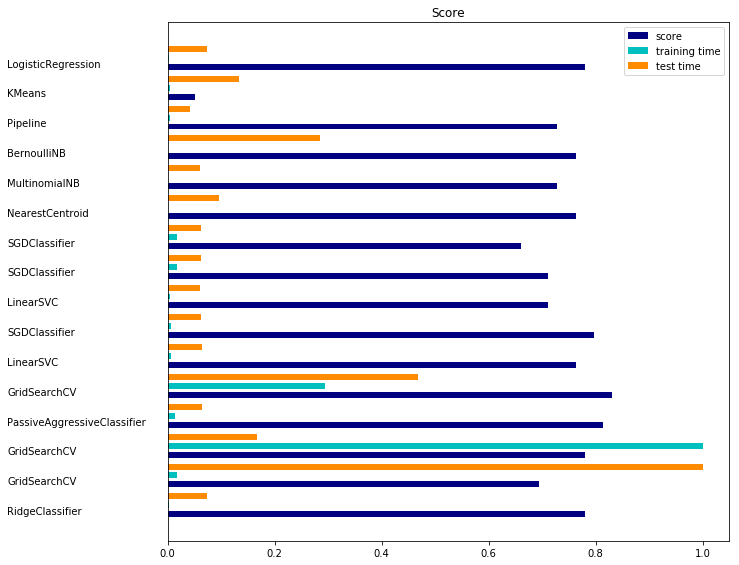

In [45]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(range(1)):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = data_for_training()
    #target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50), (300, 100),(300,200,100)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 11]}
    k_range = list(range(3,7))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            (GridSearchCV(knn,parameters_knn, cv=5),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            (GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=5),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10),parameters_RF, cv=5),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        results.append(benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    results.append(benchmark(BernoulliNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    results.append(benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)
    
    